# IIA 2024 - Aprendizaje Automatizado
### Lucas Poma
## Trabajo Practico 3

## Definiciones

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

### Redes Neuronales

In [2]:
N2 = 20
learning_rate = 0.02
momentum = 0.85
gamma = 0.00001
epochs = 30
evals = 300

In [3]:
from sklearn.neural_network import MLPClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
def MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma):
    return MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate,momentum=momentum,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epochs)

In [5]:
def error_clasificacion(y, y_pred):
    return sk.metrics.zero_one_loss(y, y_pred)

def entrenar_red_peso(red, evaluaciones, X_train, y_train, X_test, y_test):
    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
        red.fit(X_train, y_train)
        weights = red.coefs_
        weight_sum.append(sum(np.sum(np.square(w)) for w in weights))
        error_train.append(error_clasificacion(y_train, red.predict(X_train)))
        error_test.append(error_clasificacion(y_test, red.predict(X_test)))

    return red, error_train, error_test, weight_sum

### Arboles

In [6]:
from sklearn.tree import DecisionTreeClassifier

### Paralelas

In [7]:
def paralelas(n, d, C):
  half = int(n/2)

  mClass0 = np.zeros(d)
  mClass0[0] = 1
  mClass1 = np.zeros(d)
  mClass1[0] = -1
  covM = np.identity(d) * (C**2)

  class0 = np.random.multivariate_normal(mClass0, covM, half)
  class1 = np.random.multivariate_normal(mClass1, covM, n - half)

  labels0 = np.zeros((half, 1))
  labels1 = np.ones((n - half, 1))

  data0 = np.hstack((class0, labels0))
  data1 = np.hstack((class1, labels1))

  data = np.vstack((data0, data1))

  columns = [f'dim_{i}' for i in range(d)] + ['class']
  dataFrame = pd.DataFrame(data, columns=columns)

  return dataFrame

### Diagonales

In [8]:
def diagonales(n, d, C):
  half = int(n/2)

  mClass0 = -np.ones(d)
  mClass1 = np.ones(d)
  covM = np.identity(d) * (C**2 * d)

  class0 = np.random.multivariate_normal(mClass0, covM, half)
  class1 = np.random.multivariate_normal(mClass1, covM, n - half)

  labels0 = np.zeros((half, 1))
  labels1 = np.ones((n - half, 1))

  data0 = np.hstack((class0, labels0))
  data1 = np.hstack((class1, labels1))

  data = np.vstack((data0, data1))

  columns = [f'dim_{i}' for i in range(d)] + ['class']
  dataFrame = pd.DataFrame(data, columns=columns)

  return dataFrame

### Espirales

In [9]:
def inside_circle(x,y):
  return np.linalg.norm([x,y]) <= 1

def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def in_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def in_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    for i in [1, 3, 5, 7]:
        if in_curve(rho, theta, i):
            return True
    return False

def espirales(n):
  half = int(n/2)
  bothClass = []
  countClass0 = 0
  countClass1 = 0

  while (countClass0 < half or countClass1 < n-half):
    gen = np.random.uniform(-1,1,size=(half,2))
    for (x,y) in gen:
      if (inside_circle(x,y)):
        if (in_curves(x,y)):
          if (countClass0 < half):
            bothClass.append([x,y,0])
            countClass0 += 1
        else:
          if (countClass1 < n - half):
            bothClass.append([x,y,1])
            countClass1 += 1
  df = pd.DataFrame(bothClass, columns=['dim_0', 'dim_1', 'class'])
  return df

## Ejercicio 1

### Setup

In [6]:
dimensiones = [2, 4, 8, 16, 32]
overlap = 0.78
testSamples = 10000
dataParalelasTree = []
dataDiagonalesTree = []
dataParalelasRed = []
dataDiagonalesRed = []
dataParalelasBayes = []
dataDiagonalesBayes = []

### Diagonales

In [9]:
for dimension in dimensiones:
    testDiagonales10000 = diagonales(testSamples, dimension, overlap)
    X_test = testDiagonales10000.drop(columns=['class'])
    y_test = testDiagonales10000['class']

    for conjunto in range(0,20):
        dfDiagonales = diagonales(250, dimension, overlap)
        X = dfDiagonales.drop(columns=['class'])
        y = dfDiagonales['class']

        clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
        clf = clf.fit(X, y)
        errTest = 1 - clf.score(X_test, y_test)
        errEntrenamiento = 1 - clf.score(X, y)
        dataDiagonalesTree.append([dimension, conjunto, errTest, errEntrenamiento])

        clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
        best_red, _, _, _ = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)
        errTest = error_clasificacion(y_test, best_red.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_red.predict(X))
        dataDiagonalesRed.append([dimension, conjunto, errTest, errEntrenamiento])

        clfb = GaussianNB()
        clfb.fit(X, y)
        errTest = 1 - clfb.score(X_test, y_test)
        errEntrenamiento = 1 - clfb.score(X, y)
        dataDiagonalesBayes.append([dimension, conjunto, errTest, errEntrenamiento])

### Paralelas

In [11]:
for dimension in dimensiones:
    testParalelas10000 = paralelas(testSamples, dimension, overlap)
    X_test = testParalelas10000.drop(columns=['class'])
    y_test = testParalelas10000['class']

    for conjunto in range(0,20):
        dfParalelas = paralelas(250, dimension, overlap)
        X = dfParalelas.drop(columns=['class'])
        y = dfParalelas['class']
        clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
        clf = clf.fit(X, y)
        errTest = 1 - clf.score(X_test, y_test)
        errEntrenamiento = 1 - clf.score(X, y)
        dataParalelasTree.append([dimension, conjunto, errTest, errEntrenamiento])

        clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
        best_red, _, _, _ = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)
        errTest = error_clasificacion(y_test, best_red.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_red.predict(X))
        dataParalelasRed.append([dimension, conjunto, errTest, errEntrenamiento])

        clfb = GaussianNB()
        clfb.fit(X, y)
        errTest = 1 - clfb.score(X_test, y_test)
        errEntrenamiento = 1 - clfb.score(X, y)
        dataParalelasBayes.append([dimension, conjunto, errTest, errEntrenamiento])

### Resultados

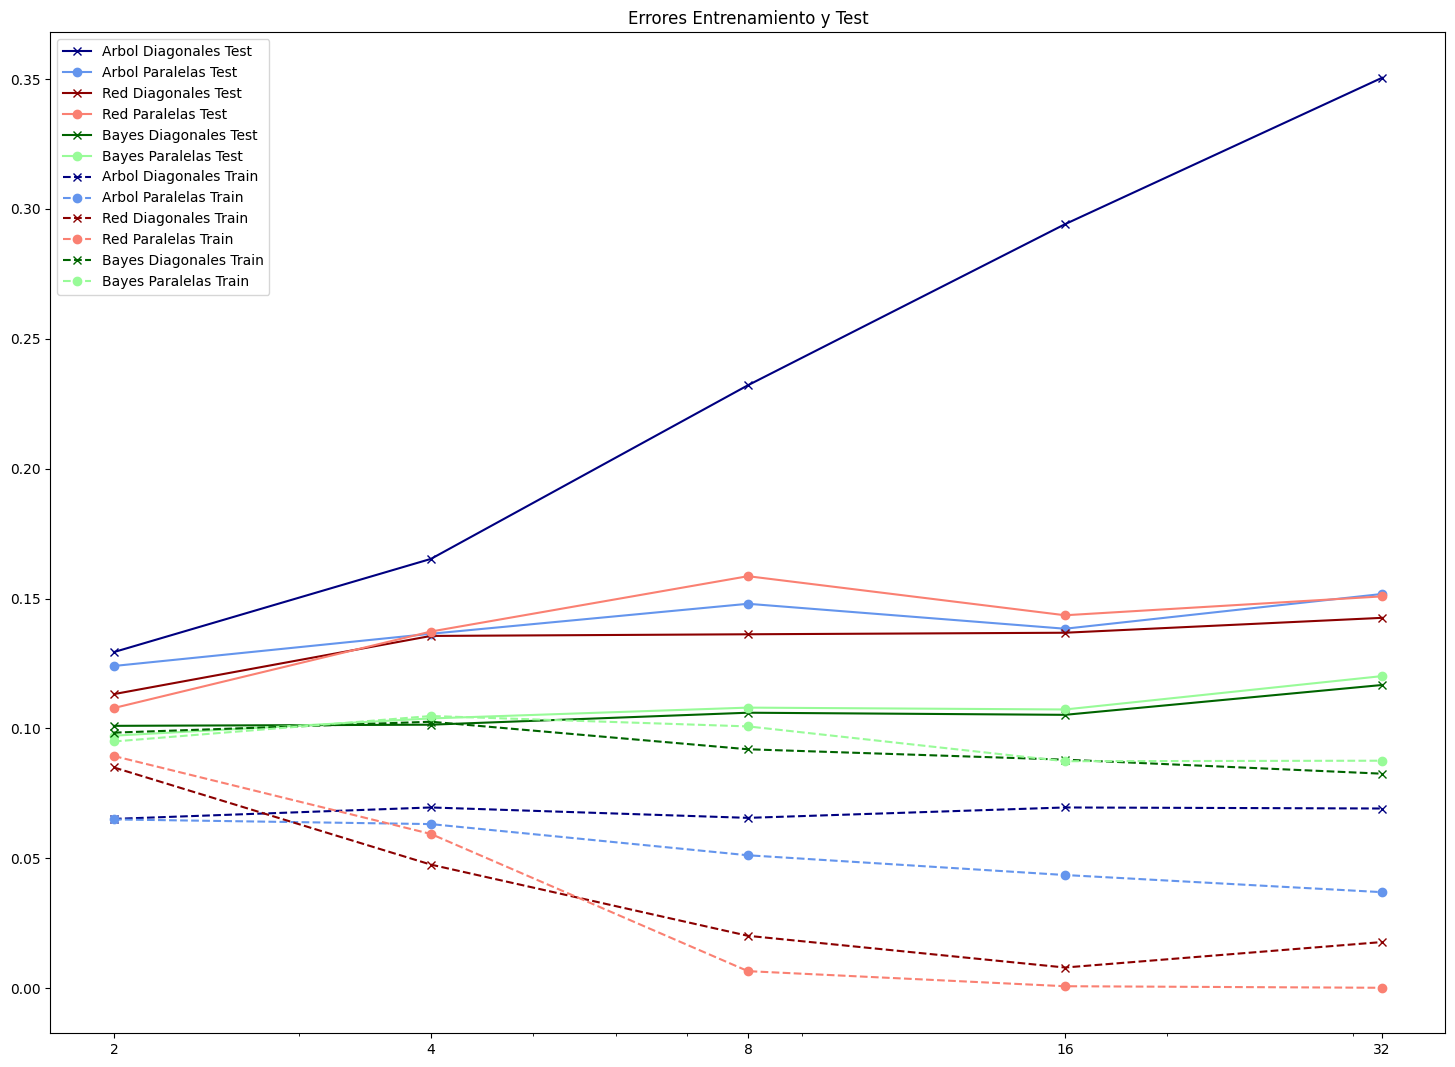

In [12]:
dfDiagonalesTree = pd.DataFrame(dataDiagonalesTree, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasTree = pd.DataFrame(dataParalelasTree, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesTree = dfDiagonalesTree.groupby('dimension')['errTest'].mean()
promsErrTestParalelasTree = dfParalelasTree.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesTree = dfDiagonalesTree.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasTree = dfParalelasTree.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesRed = pd.DataFrame(dataDiagonalesRed, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasRed = pd.DataFrame(dataParalelasRed, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesRed = dfDiagonalesRed.groupby('dimension')['errTest'].mean()
promsErrTestParalelasRed = dfParalelasRed.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesRed = dfDiagonalesRed.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasRed = dfParalelasRed.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesBayes = pd.DataFrame(dataDiagonalesBayes, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasBayes = pd.DataFrame(dataParalelasBayes, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesBayes = dfDiagonalesBayes.groupby('dimension')['errTest'].mean()
promsErrTestParalelasBayes = dfParalelasBayes.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesBayes = dfDiagonalesBayes.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasBayes = dfParalelasBayes.groupby('dimension')['errEntrenamiento'].mean()

plt.figure(figsize=(18, 13))

plt.plot(dimensiones, promsErrTestDiagonalesTree, c='navy', label='Arbol Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasTree, c='cornflowerblue', label='Arbol Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesRed, c='darkred', label='Red Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasRed, c='salmon', label='Red Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesBayes, c='darkgreen', label='Bayes Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasBayes, c='palegreen', label='Bayes Paralelas Test', marker='o', linestyle="-")

plt.plot(dimensiones, promsErrEntrenamientoDiagonalesTree, c='navy', label='Arbol Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasTree, c='cornflowerblue', label='Arbol Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesRed, c='darkred', label='Red Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasRed, c='salmon', label='Red Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesBayes, c='darkgreen', label='Bayes Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasBayes, c='palegreen', label='Bayes Paralelas Train', marker='o', linestyle="--")

plt.legend()
plt.xscale('log')
plt.title('Errores Entrenamiento y Test')
plt.xticks(dimensiones, labels=[str(dimension) for dimension in dimensiones])

plt.show()

En este problema utilizamos GaussianNB para clasificar los atributos continuos, este algoritmo asume que las probabilidades condicionales siguen una distribución normal.

Para modelar las paralelas y las diagonales, este enfoque es muy efectivo, ya que ambos casos siguen una distribución normal multivariada. Esto resulta en un buen desempeño en términos de errores de test. Y juzgando por el error de entrenamiento, que es algo elevado en comparación a redes o árboles, mostrando que es un modelo que generaliza mejor.

Además, en este contexto, la suposición de Naive Bayes de que los atributos son independientes entre sí es válida, ya que realmente lo son.

Por lo tanto, el aumento de la dimensionalidad no afecta significativamente, ya que las variables siguen siendo independientes entre sí.

## Ejercicio 2

### Dos Elipses

In [18]:
csv = pd.read_csv('DataSets/dos_elipses.data', names=['dim_0', 'dim_1', 'class']).sample(n=500)
X = csv.drop(columns=['class'])
y = csv['class']

csv = pd.read_csv('DataSets/dos_elipses.test', names=['dim_0', 'dim_1', 'class']).sample(n=2000)
X_test = csv.drop(columns=['class'])
y_test = csv['class']

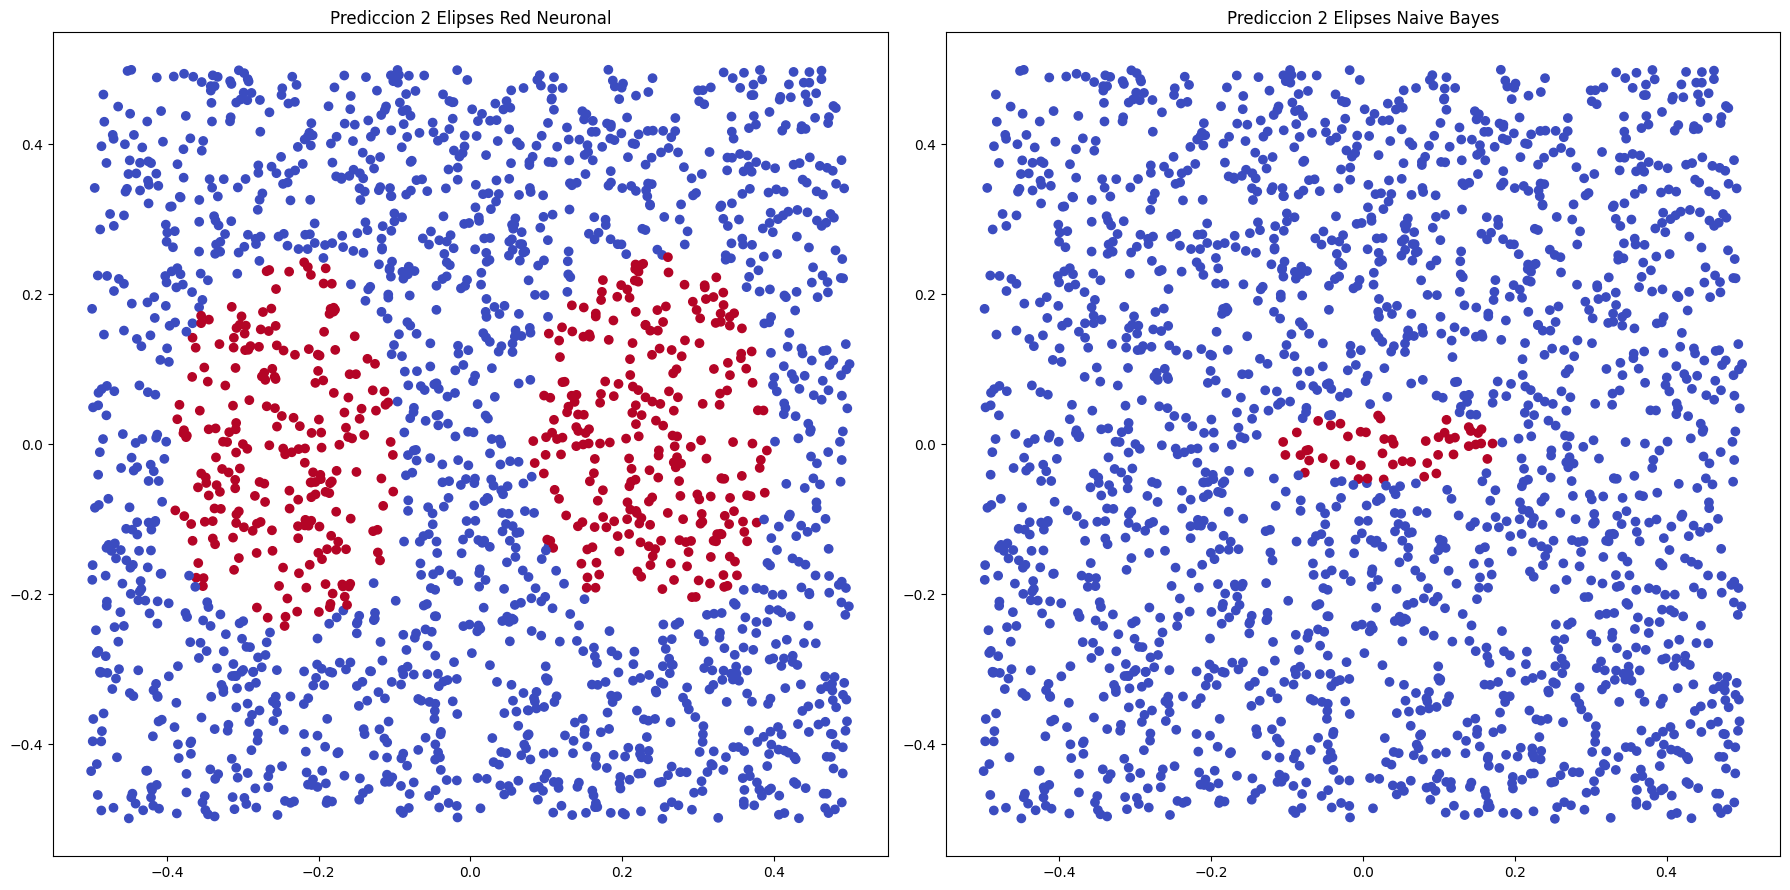

In [19]:
clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
best_red, error_train, error_val, error_test = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_red.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion 2 Elipses Red Neuronal')

clfb = GaussianNB()
clfb.fit(X, y)
ax = axs[1]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=clfb.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion 2 Elipses Naive Bayes')

plt.tight_layout()
plt.show()

### Espirales

In [68]:
espiralesTrain = espirales(600)
espiralesTest = espirales(2000)

X = espiralesTrain.drop(columns=['class'])
y = espiralesTrain['class']

X_test = espiralesTest.drop(columns=['class'])
y_test = espiralesTest['class']

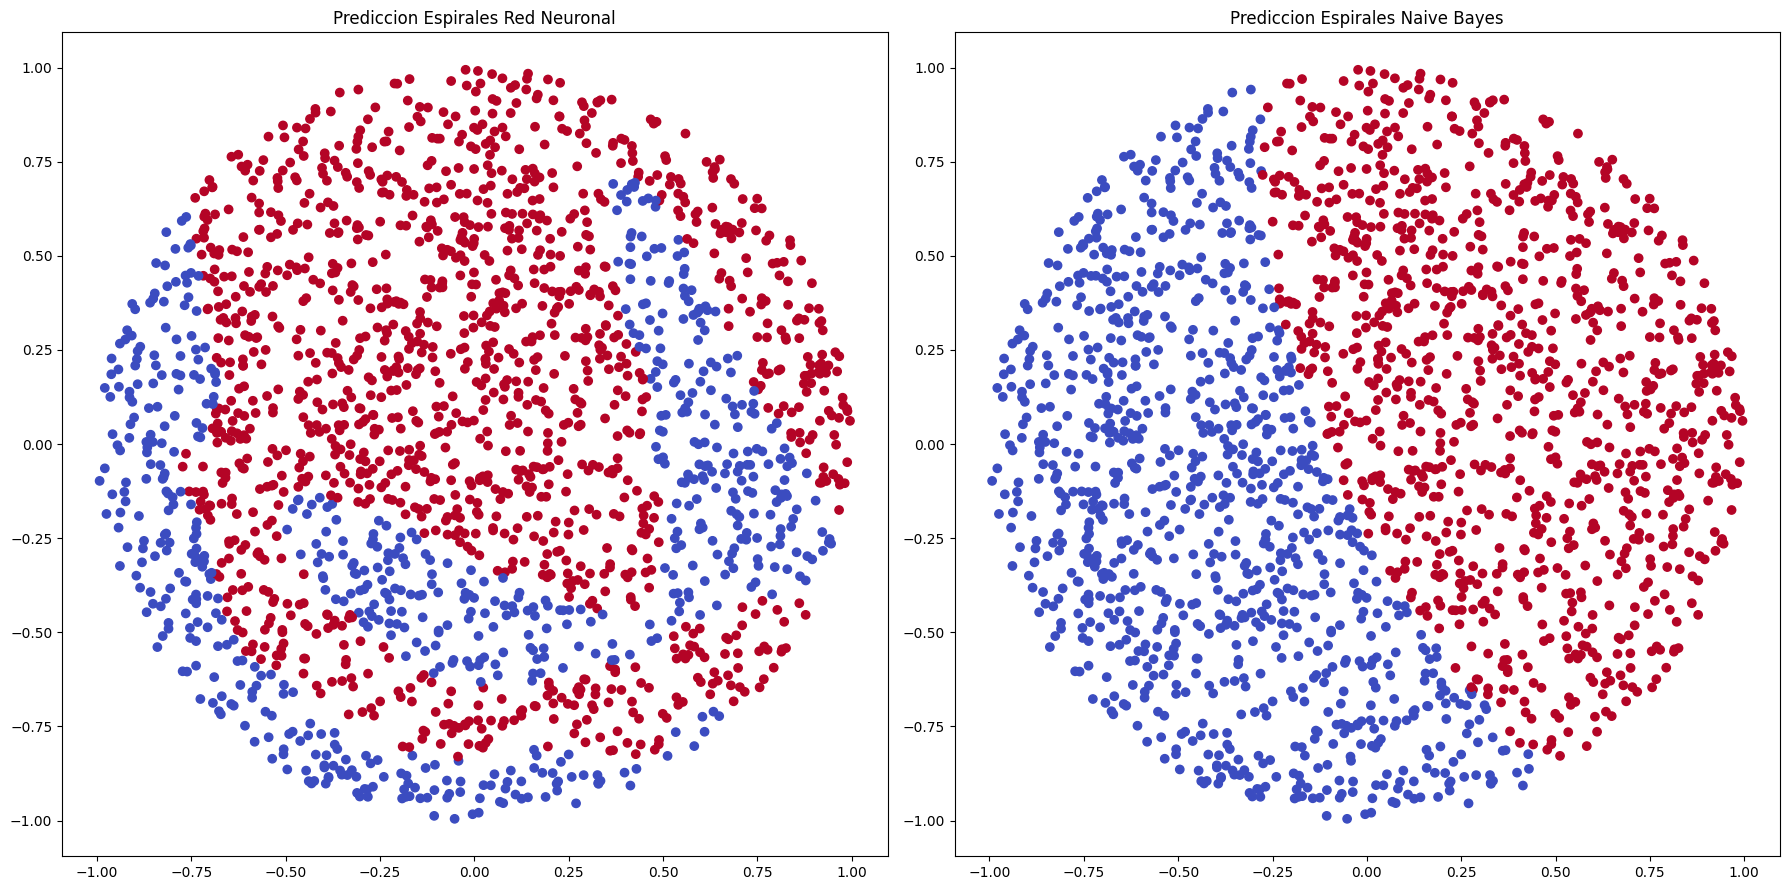

In [21]:
clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
best_red, error_train, error_val, error_test = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_red.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion Espirales Red Neuronal')

clfb = GaussianNB()
clfb.fit(X, y)
ax = axs[1]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=clfb.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion Espirales Naive Bayes')

plt.tight_layout()
plt.show()

En el problema de las dos elipses, observamos que las redes neuronales logran un modelado bastante certero, mientras que al utilizar GaussianNB obtenemos solo un cúmulo pequeño de puntos en el centro. En mi opinión, esto se debe a que al intentar modelar el problema con una distribución normal, GaussianNB encuentra el centro entre ambas elipses, generando una representación inadecuada del problema.

En el caso de las elipses, sucede algo similar, ya que los datos no siguen una distribución normal. Por ello, GaussianNB simplemente genera una división en dos para clasificar los elementos, lo que no captura adecuadamente la estructura del problema. La división planteada debe de ser completamente dependiente de la distribución del conjunto de entrenamiento hacia el lado donde aparezcan más de una clase.

## Ejercicio 3

In [22]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
bins_list = [2*x for x in range(1, 30)]

In [23]:
def error_clasificacion(y, y_pred):
    return sk.metrics.zero_one_loss(y, y_pred)

def entrenar_bayes_disc(X_train, y_train, X_val, y_val, X_test, y_test, bins_list):
    error_val = []
    error_train = []
    error_test = []
    min_error_val = float('inf')

    for bins in bins_list:
        discretizador = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        clf = CategoricalNB(min_categories=bins)
        X_discreto = discretizador.fit_transform(X_train)
        clf.fit(X_discreto,y_train)
        aux_err_val = error_clasificacion(y_val, clf.predict(discretizador.transform(X_val)))

        if aux_err_val < min_error_val:
            min_error_val = aux_err_val
            best_bayes = copy.deepcopy(clf)
            best_discretizador = copy.deepcopy(discretizador)

        error_val.append(aux_err_val)
        error_train.append(error_clasificacion(y_train, clf.predict(discretizador.transform(X_train))))
        error_test.append(error_clasificacion(y_test, clf.predict(discretizador.transform(X_test))))

    return best_bayes, best_discretizador, error_train, error_val, error_test

In [24]:
def bayes_plot_errors(ax, error_train, error_val, error_test, bins_list, title):
    ax.set_title(title)
    ax.plot(bins_list, error_train, label='Error de Entrenamiento', color='red', linestyle="-")
    ax.plot(bins_list, error_val, label='Error de Validacion', color='blue', linestyle="-")
    ax.plot(bins_list, error_test, label='Error de Test', color='green', linestyle="-")
    ax.set_xticks(bins_list, labels=[str(size) for size in bins_list])
    ax.legend()

## Ejercicio 4

In [34]:
csv = pd.read_csv('DataSets/dos_elipses.data', names=['dim_0', 'dim_1', 'class']).sample(n=500)
X = csv.drop(columns=['class'])
y = csv['class']

csv = pd.read_csv('DataSets/dos_elipses.test', names=['dim_0', 'dim_1', 'class']).sample(n=2000)
X_test = csv.drop(columns=['class'])
y_test = csv['class']

X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2)

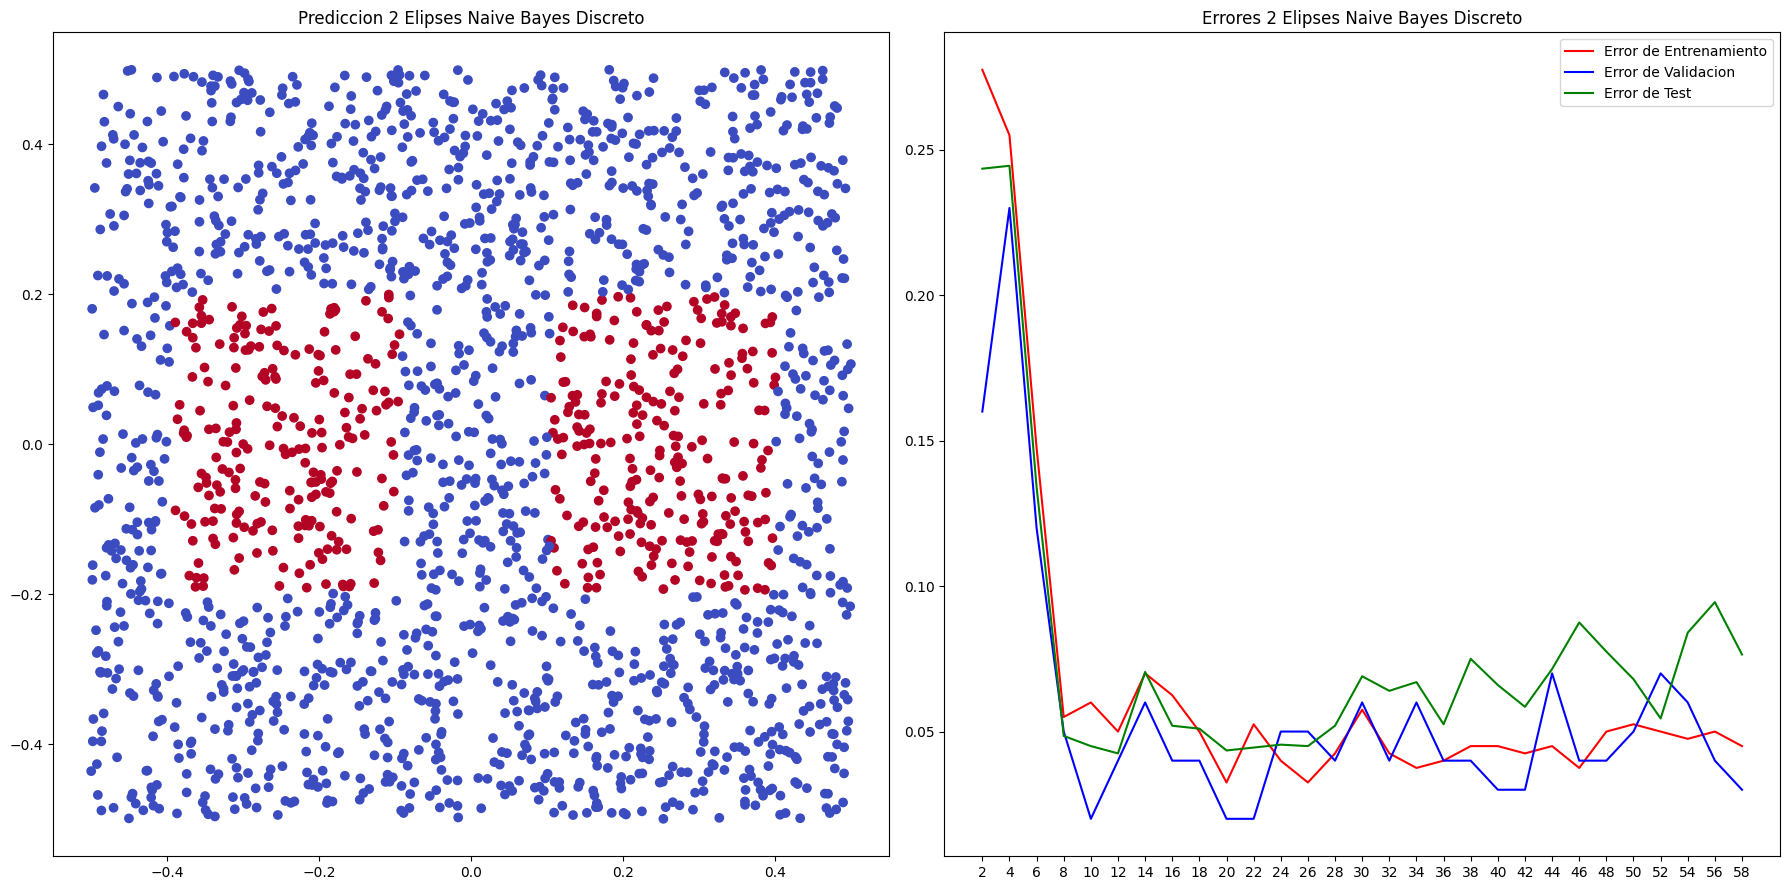

In [35]:
best_bayes, best_disc, error_train, error_val, error_test = entrenar_bayes_disc(X_train, y_train, X_val, y_val, X_test, y_test, bins_list)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))

ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_bayes.predict(best_disc.transform(X_test)), cmap='coolwarm')
ax.set_title(f'Prediccion 2 Elipses Naive Bayes Discreto')

ax = axs[1]
bayes_plot_errors(ax, error_train, error_val, error_test, bins_list, 'Errores 2 Elipses Naive Bayes Discreto')

plt.tight_layout()
plt.show()

In [46]:
espiralesTrain = espirales(600)
espiralesTest = espirales(2000)

X = espiralesTrain.drop(columns=['class'])
y = espiralesTrain['class']

X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2)

X_test = espiralesTest.drop(columns=['class'])
y_test = espiralesTest['class']

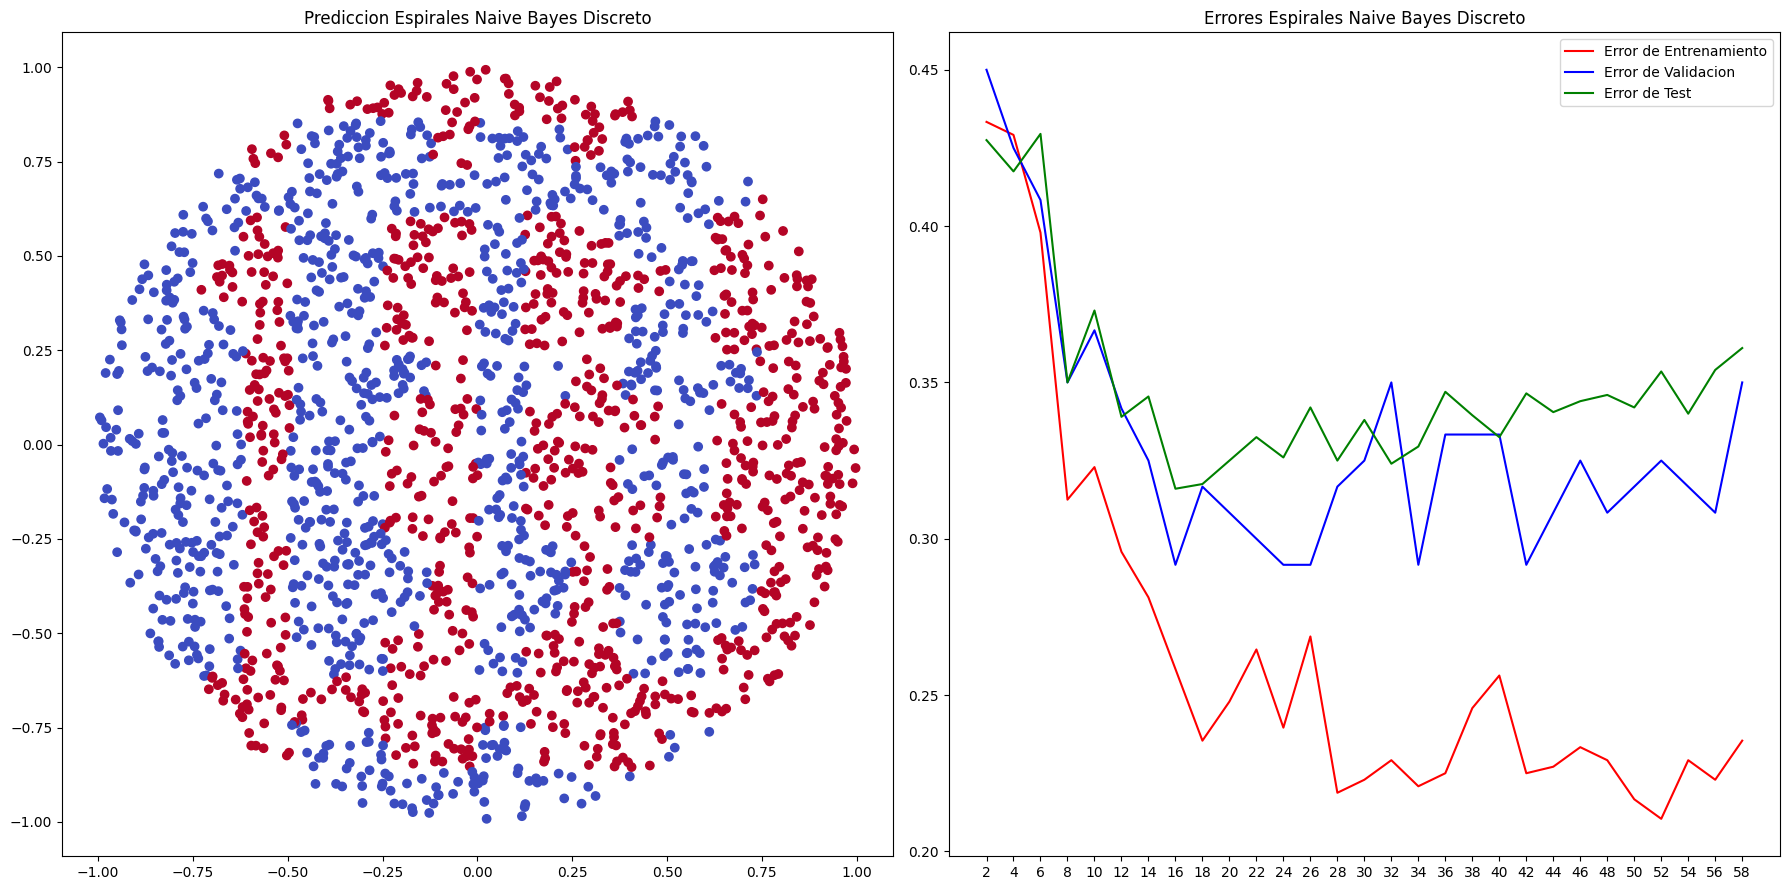

In [47]:
best_bayes, best_disc, error_train, error_val, error_test = entrenar_bayes_disc(X_train, y_train, X_val, y_val, X_test, y_test, bins_list)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))

ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=best_bayes.predict(best_disc.transform(X_test)), cmap='coolwarm')
ax.set_title(f'Prediccion Espirales Naive Bayes Discreto')

ax = axs[1]
bayes_plot_errors(ax, error_train, error_val, error_test, bins_list, 'Errores Espirales Naive Bayes Discreto')

plt.tight_layout()
plt.show()

A diferencia de GaussianNB, que asume que las características siguen una distribución normal, CategoricalNB trabaja con datos categóricos y modela la probabilidad condicional de cada característica como una distribución categórica.

CategoricalNB calcula las frecuencias de cada categoría para cada característica en cada clase del conjunto de datos de entrenamiento. Estas frecuencias se utilizan para estimar las probabilidades condicionales.

Esto hace que CategoricalNB sea más efectivo en problemas donde los datos no siguen una distribución normal.

En el problema de las dos elipses, CategoricalNB muestra un buen desempeño. Sin embargo, a medida que aumentamos el número de bins, se produce un mayor sobreajuste, especialmente cuando se superan los 30 bins. Obtenemos el mejor resultado con 10 bins y observamos que, al discretizarse los datos, los bordes de las elipses se vuelven rectos.

En el problema de las espirales, CategoricalNB también ofrece un mejor rendimiento en comparación con la suposición de una distribución normal, aunque no es perfecto. Similar a lo que ocurre con los árboles de decisión, los cortes son pronunciadamente rectos. Se observa un claro sobreajuste al superar aproximadamente los 20 bins.



## Ejercicio 5


In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_20newsgroups
X, y = fetch_20newsgroups(subset="train", return_X_y=True, remove=("headers",))
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25, random_state=1)
X_test, y_test = fetch_20newsgroups(subset="test", return_X_y=True, remove=("headers",))

In [26]:
alfas = [(10**(-x)) for x in range(0, 5)]
largos = [500, 1000, 2000, 4000, 8000, 16000]
data = []

In [27]:
def entrenar_bayes_multi(alfa, X_train, y_train, X_val, y_val, X_test, y_test):
    aux_error_val = float('inf')
    for alfa in alfas:
        for largo in largos:
            vec = CountVectorizer(stop_words='english',max_features=largo)
            Xvec_train = vec.fit_transform(X_train).toarray()
            Xvec_val = vec.transform(X_val).toarray()
            Xvec_test = vec.transform(X_test).toarray()
            clf = MultinomialNB(alpha=alfa)
            clf.fit(Xvec_train, y_train)
            error_val = error_clasificacion(y_val, clf.predict(Xvec_val))
            error_train = error_clasificacion(y_train, clf.predict(Xvec_train))
            error_test = error_clasificacion(y_test, clf.predict(Xvec_test))
            data.append([alfa, largo, error_val, error_train, error_test])

            if error_val < aux_error_val:
                aux_error_val = error_val
                best_bayes = copy.deepcopy(clf) 
                best_vectorizador = copy.deepcopy(vec)
                
    return best_bayes, best_vectorizador

In [28]:
mejorBayes, mejorVectorizador = entrenar_bayes_multi(alfas, X_train, y_train, X_val, y_val, X_test, y_test)
table = pd.DataFrame(data, columns=['Alfa', 'Largo Dict', 'Error Validacion', 'Error Entrenamiento', 'Error Test'])

Minimo error de validacion

    Alfa  Largo Dict  Error Validacion  Error Entrenamiento  Error Test
17  0.01       16000          0.168257              0.05822    0.253452


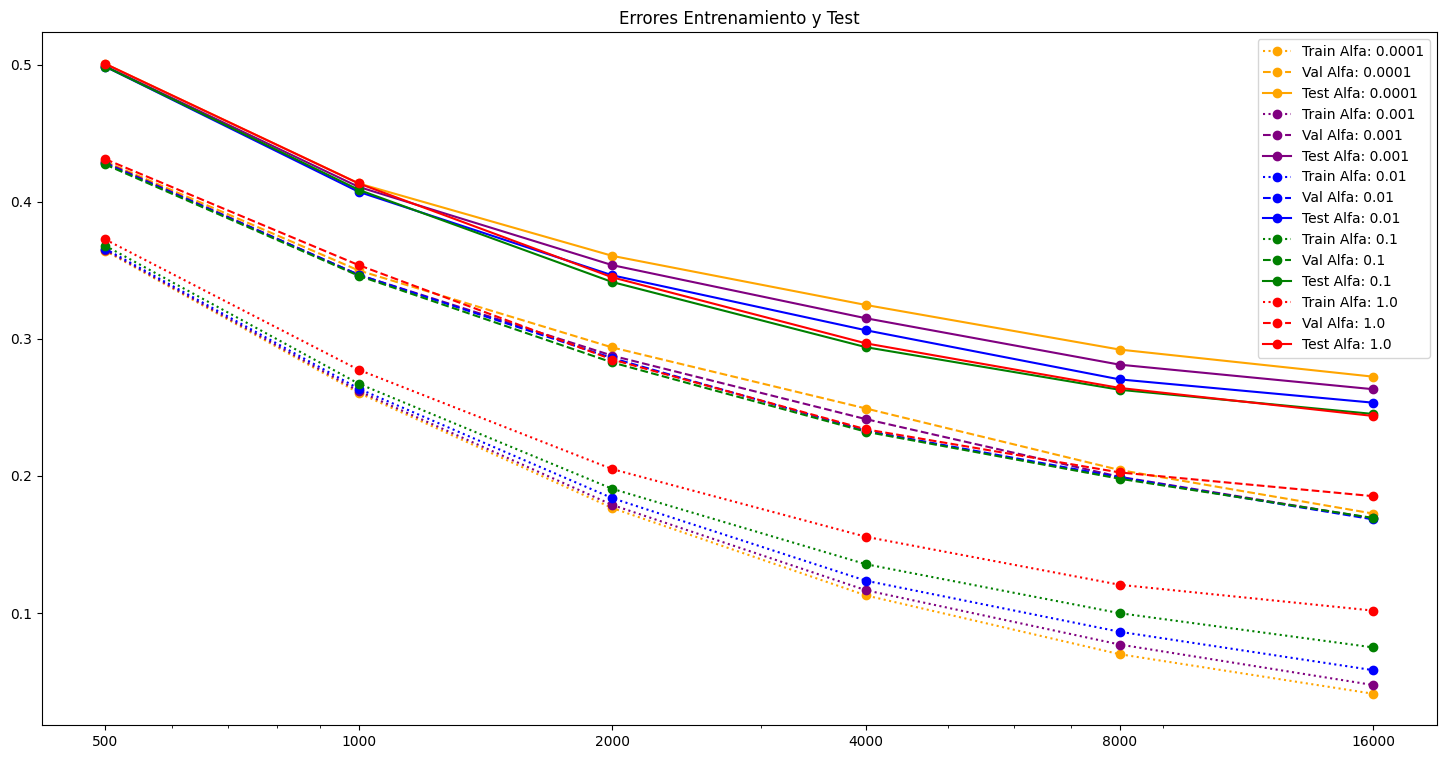

In [29]:
linestyles = [':', '--', '-']
colors = ['red', 'green', 'blue', 'purple', 'orange']
colors = {alfas[i]: colors[i] for i in range(len(alfas))}

print("Minimo error de validacion\n")
mejorErrorValidacion = table[table['Error Validacion'] == table['Error Validacion'].min()]
print(mejorErrorValidacion)

tableAlfa = table.groupby('Alfa')
plt.figure(figsize=(18, 9))
for name, group in tableAlfa:
    plt.plot(group['Largo Dict'], group['Error Entrenamiento'], color=colors[name], linestyle=linestyles[0], marker='o', label=f'Train Alfa: {name}')
    plt.plot(group['Largo Dict'], group['Error Validacion'], color=colors[name], linestyle=linestyles[1], marker='o', label=f'Val Alfa: {name}')
    plt.plot(group['Largo Dict'], group['Error Test'], color=colors[name], linestyle=linestyles[2], marker='o', label=f'Test Alfa: {name}')

plt.xscale('log')
plt.xticks(largos, labels=[str(largo) for largo in largos])
plt.legend()
plt.title('Errores Entrenamiento y Test')
plt.show()

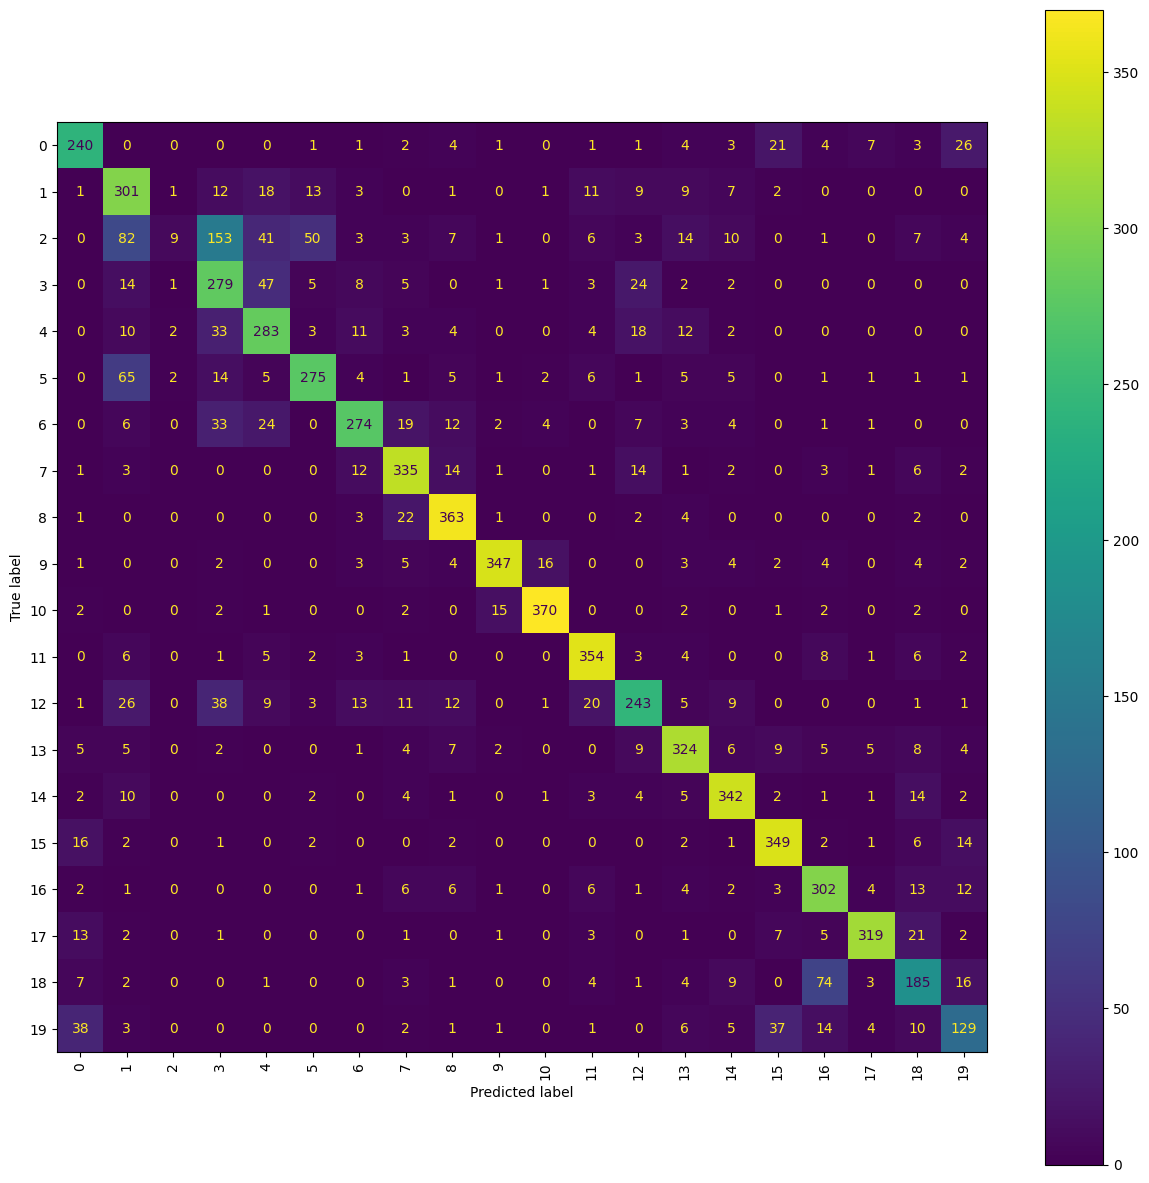

In [30]:
matrix = confusion_matrix(y_test, mejorBayes.predict(mejorVectorizador.transform(X_test)), labels=mejorBayes.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=mejorBayes.classes_)

fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.show()

De lo obtenido y observando las gráficas, pareciera que aumentar el tamaño del diccionario siempre genera una mejora en la disminución de errores, y que un alfa cercano a 0.1 es el mejor parámetro. 

Como se puede ver en la gráfica, al tomar el mismo tamaño de diccionario, con los alfas más pequeños (línea amarilla, violeta), se observa cierto sobreajuste en comparación con un alfa de 0.1 o 1, ya que los errores de entrenamiento son menores pero el de test es mayor. 
Esto se puede dar ya que a valores muy pequeños de alfa no proveen el suficiente suavizado en contabilizar las probabilidades que serian 0.

El error de validación es algo menor que el de test, pero ambos se mueven de manera correlacionada, por lo que el conjunto de validación parece ser un buen representante del conjunto de test.

Una particularidad observada en la matriz de confusión del conjunto de test es que este modelo es muy malo clasificando la clase 2, tendiendo a clasificarla mayoritariamente como clase 1 o 3.